# Elasto-inertial Turbulence

In this notebook, the Callaham et al. paper's method is used on simulation data of a polymer-laden flow, where the governing equation is much more complex, and some dominant balance regimes may be unknown still, unlike for well-studied cases in the paper (e.g. Turbulent Boundary Layer, Geostrophic Balance,...)

The governing equation is here given by:

$$ \partial_{t}\mathbf{u} + (\mathbf{u} \cdot \mathbf{\nabla})\mathbf{u} + \mathbf{\nabla}p = \frac{\beta}{Re} \Delta \mathbf{u} + \frac{1 - \beta}{Re} \mathbf{\nabla} \cdot \mathbf{T}(\mathbf{C}) $$

where

$ \mathbf{T}(\mathbf{C}) := \frac{1}{Wi}(f(\text{tr}\mathbf{C})\mathbf{C} - \mathbf{I}) $, and $ f(x) := (1 - \frac{x - 3}{L_{max}^{2}})^{-1} $.



Thus, $\mathbf{T}(\mathbf{C}) = \frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1}\mathbf{C} - \mathbf{I}) $



In [114]:
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf

## 1. Load the data

In [115]:
# Load the data
path = "../Data/39_60_512_512_CAR.h5"
data = h5py.File(path, "r")

print(data.keys())

<KeysViewHDF5 ['c11', 'c12', 'c22', 'c33', 'p', 'time', 'u', 'v']>


In this dataset are:
- The 4 components of the Conformation Tensor C; $\mathbf{C}_{xx}, \mathbf{C}_{yy}, \mathbf{C}_{zz}, \mathbf{C}_{xy}$.
- The time for which the snapshot corresponds to, t.
- (u, v), the streamwise and wall-normal velocity components
- p, the pressure

They have the following size:
[Seed/Trajectory number, Snapshot number, Nx, Ny], except for time which is just [Seed/Trajectory number, Snapshot number]

There is a few dimensionless parameters that must be set, and these have values set for the data simulation (for CAR statistically steady state):

- $Re = 1000$, the Reynolds number
- $Wi = 50$, the Weissenberg number
- $beta = 0.9$, denotes the viscosity ratio of solvent/polymer contributions to the total kinematic viscosity
- $L_{max} = 70$, the maximum extensibility of the polymer chains
- $[L_{x}, L_{y}] = [2, 2 \pi]$, the domain extents, in units of h (the half-distance between the plates)


In [116]:
# Set some constants
Re = 1000
Wi = 50
beta = 0.9
Lmax = 70
Lx = 2 * np.pi
Ly = 2

## 2. Get the equation space representation of the data

First, the x-component of the governing equation is studied. This is given as:

$$ \partial_{t}u + u u_{x} + v u_{y} + p_{x} = \frac{\beta}{Re} (u_{xx} + u_{yy}) + \frac{1 - \beta}{Re} ( (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{xx} - 1))_{x} + (\frac{1}{Wi} ((1 - \frac{(\text{tr}\mathbf{C}) - 3}{L_{max}^{2}})^{-1} C_{yy} - 1))_{y} ) $$




Thus the variables needed are:
- $u, \partial u/\partial x, \partial^{2} u/ \partial x^{2}, \partial u/\partial y, \partial^{2} u/ \partial y^{2}, \partial p/\partial x$, and the x-derivative and y-derivative of those last two RHS terms

In [117]:
traj_seed = 0
snapshot = 0

In [118]:
u = data["u"][traj_seed, snapshot : snapshot + 2, :, :]
v = data["v"][traj_seed, snapshot, :, :]
p = data["p"][traj_seed, snapshot, :, :]
Cxx = data["c11"][traj_seed, snapshot, :, :]
Cxy = data["c12"][traj_seed, snapshot, :, :]
Cyy = data["c22"][traj_seed, snapshot, :, :]
t1 = data["time"][traj_seed, snapshot]
t2 = data["time"][traj_seed, snapshot + 1]

trC = Cxx + Cyy

In [119]:
t1, t2

(977.0, 978.0)

In [120]:
u.shape

(2, 512, 512)

In [121]:
# Get the derivatives

u_t = (u[0] - u[1]) / (t2 - t1)

nx = u.shape[2]
ny = u.shape[1]

u_x, u_y = np.gradient(u[0], Ly / ny, Lx / nx)
p_x = np.gradient(p, Lx / nx, axis=1)

u_xx = np.gradient(u_x, Lx / nx, axis=1)
u_yy = np.gradient(u_y, Ly / ny, axis=0)

In [122]:
# Define the RHS terms

RHS1 = (beta / Re) * (u_xx + u_yy)
RHS2 = (1 / Wi) * ((1 / (1 - (trC - 3) / (Lmax**2))) * Cxx - 1)
RHS3 = (1 / Wi) * ((1 / (1 - (trC - 3) / (Lmax**2))) * Cyy - 1)

RHS2 = (1 - beta) / Re * np.gradient(RHS2, Lx / nx, axis=1)
RHS3 = (1 - beta) / Re * np.gradient(RHS3, Ly / ny, axis=0)

Text(0, 0.5, 'p_x')

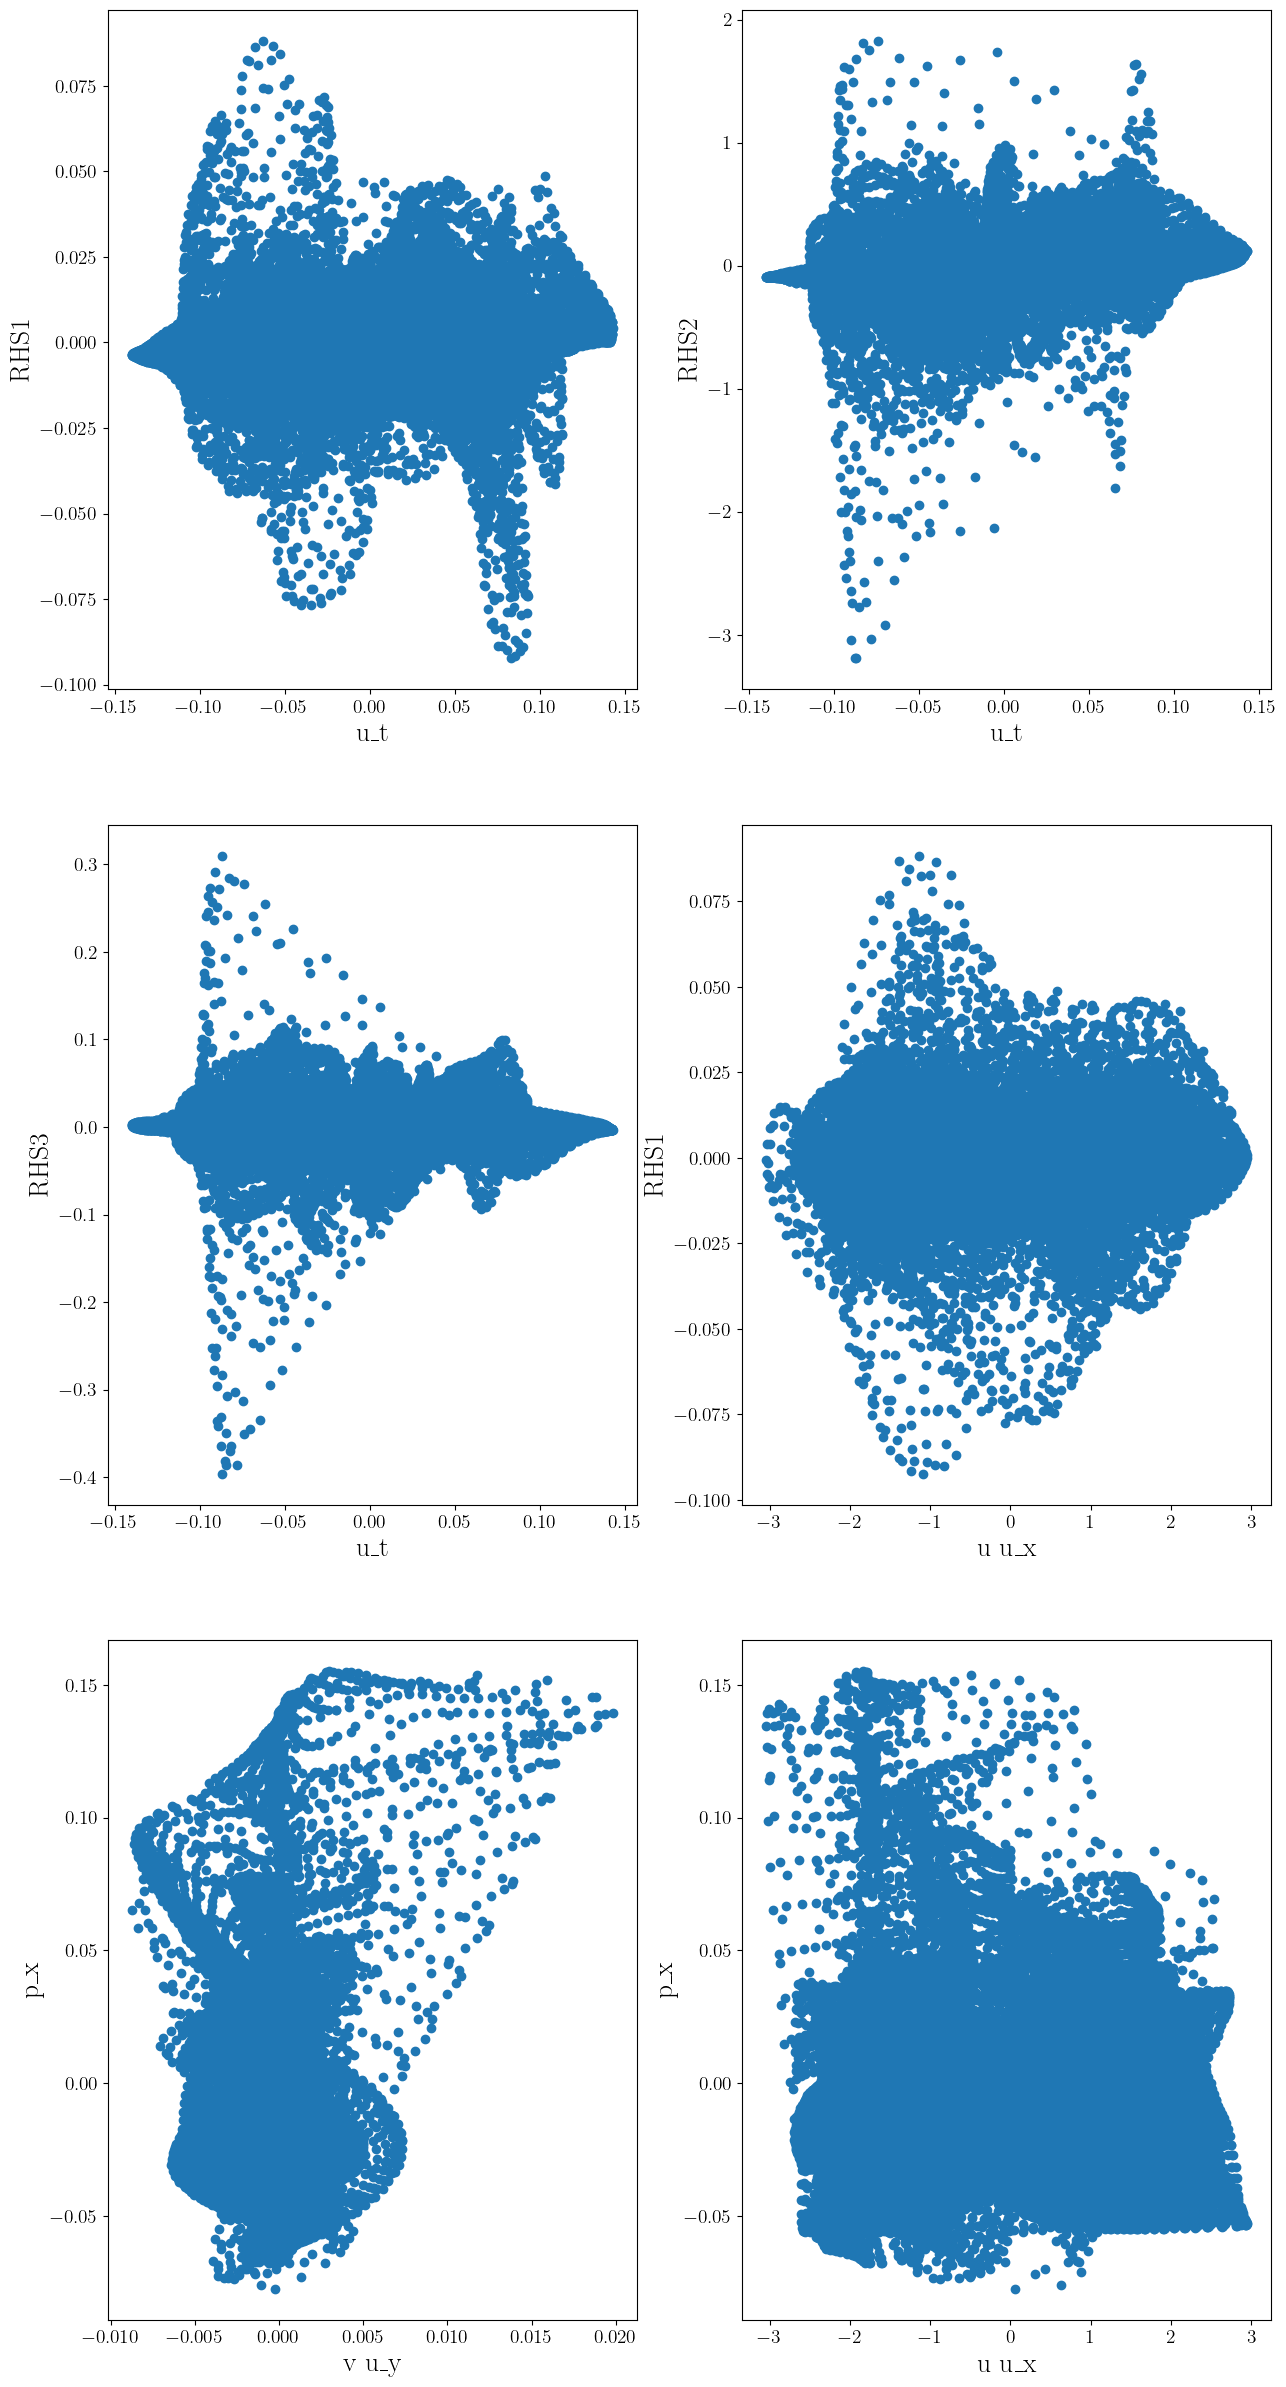

In [123]:
# Plot some scatter plots
fig = plt.subplots(3, 2, figsize=(15, 30))

plt.subplot(3, 2, 1)
plt.scatter(u_t.flatten(), RHS1.flatten())
plt.xlabel("u_t")
plt.ylabel("RHS1")

plt.subplot(3, 2, 2)
plt.scatter(u_t.flatten(), RHS2.flatten())
plt.xlabel("u_t")
plt.ylabel("RHS2")

plt.subplot(3, 2, 3)
plt.scatter(u_t.flatten(), RHS3.flatten())
plt.xlabel("u_t")
plt.ylabel("RHS3")

plt.subplot(3, 2, 4)
plt.scatter((u[0] * u_x).flatten(), RHS1.flatten())
plt.xlabel("u u_x")
plt.ylabel("RHS1")

plt.subplot(3, 2, 5)
plt.scatter((v * u_y).flatten(), p_x.flatten())
plt.xlabel("v u_y")
plt.ylabel("p_x")

plt.subplot(3, 2, 6)
plt.scatter((u[0] * u_x).flatten(), p_x.flatten())
plt.xlabel("u u_x")
plt.ylabel("p_x")

In [124]:
# Define the features:

features = pd.DataFrame(
    {
        "u_t": u_t.flatten(),
        "uu_x": (u[0] * u_x).flatten(),
        "vu_y": (v * u_y).flatten(),
        "p_x": p_x.flatten(),
        "nondim_Lap_u": (RHS1).flatten(),
        "tensor1": RHS2.flatten(),
        "tensor2": RHS3.flatten(),
    }
)

features = features.to_numpy()

In [125]:
labels = [
    r"$u_{t}$",
    r"$u u_{x}$",
    r"$v u_{y}$",
    r"$p_{x}$",
    r"$\nabla^2 u$",
    r"${Tensor 1}$",
    r"${Tensor 2}$",
]

In [126]:
print(features.shape)
print(len(features))

(262144, 7)
262144


## 3. Cluster using GMM

In [127]:
# Set the random seeds
seed = 75016
np.random.seed(seed)

# Get a subset of the data
frac = 0.3
features_training = train_test_split(features, train_size=frac, random_state=seed)[0]

# Set number of clusters
n_clusters = 8

# Define the model
GMM = GaussianMixture(n_components=n_clusters, random_state=seed)

# Fit the model
GMM.fit(features_training)

GaussianMixture(n_components=8, random_state=75016)

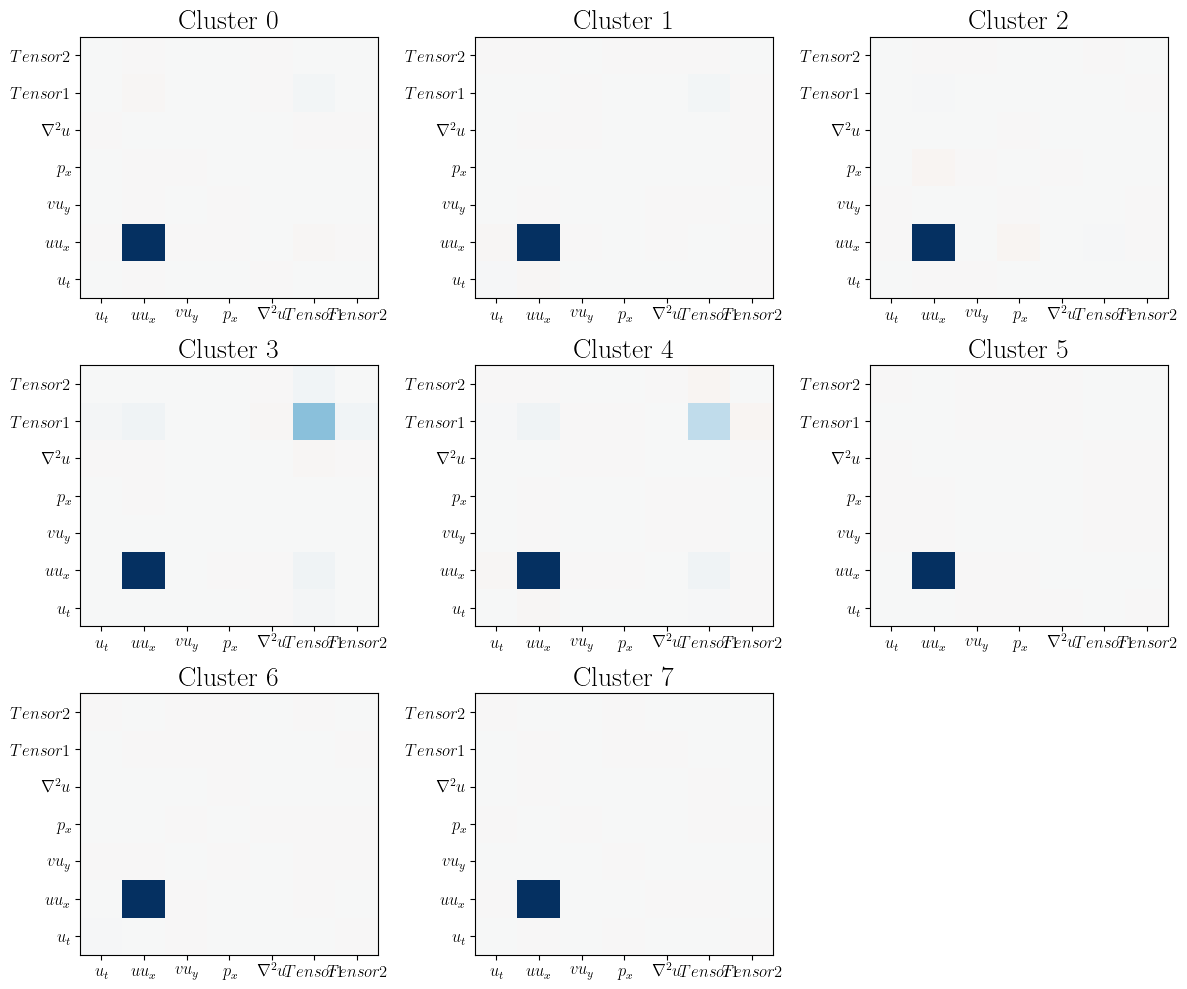

In [128]:
# Plot the covariance matrices of each cluster

pf.plot_cov_mat(GMM, features.shape[1], n_clusters, labels, "GMM")

In [129]:
# Predict the clusters for the entire dataset
cluster_idx = GMM.predict(features)

In [130]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import seaborn as sns

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)
cm.set_bad("darkgrey")

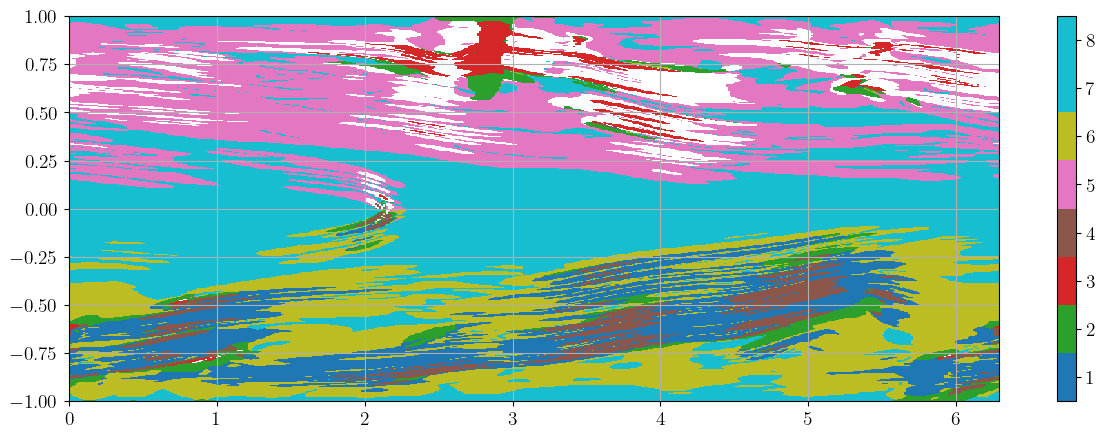

In [131]:
# Plot the clusters in space

fig = plt.figure(figsize=(15, 5))

X, Y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(-Ly / 2, Ly / 2, ny))

plt.pcolormesh(X, Y, cluster_idx.reshape(ny, nx), cmap=cm)
plt.colorbar(
    boundaries=np.arange(0.5, n_clusters + 1.5), ticks=np.arange(0, n_clusters + 1)
)
plt.grid()